### In the name of God
### Deep Learning HW5
### Variational Autoencoder



**Name:** ...

**Std. No.:** ...

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import os
import pickle
import datetime

In [2]:
import numpy as np 
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

### Variational Autoencoder Model

In [3]:
class EnocderBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride, kernel, pad):
        super().__init__()
        ########################## TODO ##########################
        # define a 2d convolutional layer based on input parameters (input_channels, output_channels, stride, kernel, pad)
        # define a 2d batch normalization layer based on input parameters (output_channels)
        # define relu activation function with inplace=True
        
        self.conv = None
        self.bn = None
        self.relu = None
        ######################## ( End ) ########################
        

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class Encoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, n_neurons_in_middle_layer):
        self.n_neurons_in_middle_layer = n_neurons_in_middle_layer
        super().__init__()
        self.bottle = EnocderBlock(color_channels, 32, stride=1, kernel=1, pad=0)
        self.m1 = EnocderBlock(32, 64, stride=1, kernel=3, pad=1)
        self.m2 = EnocderBlock(64, 128, stride=pooling_kernels[0], kernel=3, pad=1)
        self.m3 = EnocderBlock(128, 256, stride=pooling_kernels[1], kernel=3, pad=1)

    def forward(self, x):
        out = self.m3(self.m2(self.m1(self.bottle(x))))
        return out.view(-1, self.n_neurons_in_middle_layer)

class DecoderBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride, activation="relu"):
        super().__init__()
        ########################## TODO ##########################
        # define a 2d transposed convolutional layer based on input parameters (input_channels, output_channels, stride, kernel)
        # define a 2d batch normalization layer based on input parameters (output_channels)
        # define relu (with inplace=True) or sigmoid activation function based on activation parameter
        self.convt = None
        self.bn = None
        self.activation = None
        ######################## ( End ) #########################
        

    def forward(self, x):
        return self.activation(self.bn(self.convt(x)))

class Decoder(nn.Module):
    def __init__(self, color_channels, pooling_kernels, decoder_input_size):
        self.decoder_input_size = decoder_input_size
        super().__init__()
        self.m1 = DecoderBlock(256, 128, stride=1)
        self.m2 = DecoderBlock(128, 64, stride=pooling_kernels[1])
        self.m3 = DecoderBlock(64, 32, stride=pooling_kernels[0])
        self.bottle = DecoderBlock(32, color_channels, stride=1, activation="sigmoid")

    def forward(self, x):
        out = x.view(-1, 256, self.decoder_input_size, self.decoder_input_size)
        out = self.m3(self.m2(self.m1(out)))
        return self.bottle(out)

class CNN_VAE(nn.Module):
    def __init__(self, dataset):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        super().__init__()
        # # latent features
        self.n_latent_features = 64

        # resolution
        # fashion-mnist : 28 -> 14 -> 7
        pooling_kernel = [2, 2]
        encoder_output_size = 7

        # color channels of fashion-mnist
        color_channels = 1

        # neurons int middle layer
        n_neurons_middle_layer = 256 * encoder_output_size * encoder_output_size

        # Encoder
        self.encoder = Encoder(color_channels, pooling_kernel, n_neurons_middle_layer)
        
        # Middle
        # form n_neurons_middle_layer to n_latent_features (mean)
        self.fc1 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        # form n_neurons_middle_layer to n_latent_features (log_var)
        self.fc2 = nn.Linear(n_neurons_middle_layer, self.n_latent_features)
        self.fc4 = nn.Linear(self.n_latent_features, n_neurons_middle_layer)
        
        # Decoder
        self.decoder = Decoder(color_channels, pooling_kernel, encoder_output_size)

        # data
        self.train_loader, self.test_loader = self.load_data(dataset)
        # history
        self.history = {"loss":[], "val_loss":[]}

        # model name
        self.model_name = dataset + '_vae'
        if not os.path.exists(self.model_name):
            os.mkdir(self.model_name)

    def _reparameterize(self, mu, logvar):
        ########################## TODO ##########################
        # implement  reparameterization trick  (var=e^(0.5×log_var))
        std = None
        esp = None
        z = None
        return z
        ######################## ( End ) #########################

    def _bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self._reparameterize(mu, logvar)
        return z, mu, logvar

    def sampling(self):
        ########################## TODO ##########################
        # Generate a random batch of z from ~ N(0, 1) and send it to device
        z = None
        ######################## ( End ) #########################
        
        z = self.fc4(z)
        # decode
        return self.decoder(z)

    def forward(self, x):
        ########################## TODO ##########################
        # Complete the flow : x - > (encoder -> _bottleneck -> fc4 -> decoder) -> decoder_out
        h = None
        z, mu, logvar = None
        z = None
        decoder_out = None
        return decoder_out, mu, logvar
        ######################## ( End ) #########################

    # Data
    def load_data(self, dataset):
        data_transform = transforms.Compose([
                transforms.ToTensor()
        ])

        train = FashionMNIST(root="./data", train=True, transform=data_transform, download=True)
        test = FashionMNIST(root="./data", train=False, transform=data_transform, download=True)

        train_loader = torch.utils.data.DataLoader(train, batch_size=126, shuffle=True, num_workers=0)
        test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=True, num_workers=0)
        self.classes = train.classes

        return train_loader, test_loader

    # Model
    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD

    def init_model(self):
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)

        if self.device == "cuda":
            self = self.cuda()
            torch.backends.cudnn.benchmark=True
        self.to(self.device)

    # Train
    def fit_train(self, epoch):
        self.train()
        print(f"\nEpoch: {epoch+1:d} {datetime.datetime.now()}")
        train_loss = 0
        samples_cnt = 0
        for batch_idx, (inputs, _) in enumerate(self.train_loader):
            inputs = inputs.to(self.device)
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self(inputs)

            loss = self.loss_function(recon_batch, inputs, mu, logvar)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            samples_cnt += inputs.size(0)

            if batch_idx%50 == 0:
                print(batch_idx, len(self.train_loader), f"Loss: {train_loss/samples_cnt:f}")

        self.history["loss"].append(train_loss/samples_cnt)

    def test(self, epoch):
        self.eval()
        val_loss = 0
        samples_cnt = 0
        with torch.no_grad():
            for batch_idx, (inputs, _) in enumerate(self.test_loader):
                inputs = inputs.to(self.device)
                recon_batch, mu, logvar = self(inputs)
                val_loss += self.loss_function(recon_batch, inputs, mu, logvar).item()
                samples_cnt += inputs.size(0)

                if batch_idx == 0:
                    save_image(recon_batch, f"{self.model_name}/reconstruction_epoch_{str(epoch)}.png", nrow=8)

        print(batch_idx, len(self.test_loader), f"ValLoss: {val_loss/samples_cnt:f}")
        self.history["val_loss"].append(val_loss/samples_cnt)

        # sampling
        save_image(self.sampling(), f"{self.model_name}/sampling_epoch_{str(epoch)}.png", nrow=8)

    # save results
    def save_history(self):
        with open(f"{self.model_name}/{self.model_name}_history.dat", "wb") as fp:
            pickle.dump(self.history, fp)


net = CNN_VAE("fashion-mnist")
net.init_model()
# based on your resources you can choose number of epochs from 10 to 40
for i in range(40):
    net.fit_train(i)
    net.test(i)
net.save_history()


Epoch: 1 2023-10-12 14:52:34.159930


D:\Term3\Python Projects\venv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 477 Loss: 634.874194
50 477 Loss: 540.295718
100 477 Loss: 477.182630
150 477 Loss: 449.568532
200 477 Loss: 432.258927
250 477 Loss: 419.594415
300 477 Loss: 409.312303
350 477 Loss: 400.649571
400 477 Loss: 393.288958
450 477 Loss: 386.614901
156 157 ValLoss: 334.531533

Epoch: 2 2023-10-12 14:52:52.181470
0 477 Loss: 339.441127
50 477 Loss: 325.718363
100 477 Loss: 323.069373
150 477 Loss: 320.050552
200 477 Loss: 317.889614
250 477 Loss: 315.569992
300 477 Loss: 313.299553
350 477 Loss: 311.207320
400 477 Loss: 309.357641
450 477 Loss: 307.473203
156 157 ValLoss: 295.340778

Epoch: 3 2023-10-12 14:53:05.144913
0 477 Loss: 291.066623
50 477 Loss: 289.100386
100 477 Loss: 288.084157
150 477 Loss: 286.900551
200 477 Loss: 285.272566
250 477 Loss: 284.227457
300 477 Loss: 283.475221
350 477 Loss: 282.577277
400 477 Loss: 281.817649
450 477 Loss: 280.946449
156 157 ValLoss: 274.023330

Epoch: 4 2023-10-12 14:53:18.225111
0 477 Loss: 282.950552
50 477 Loss: 271.812035
100 477 Loss: 270

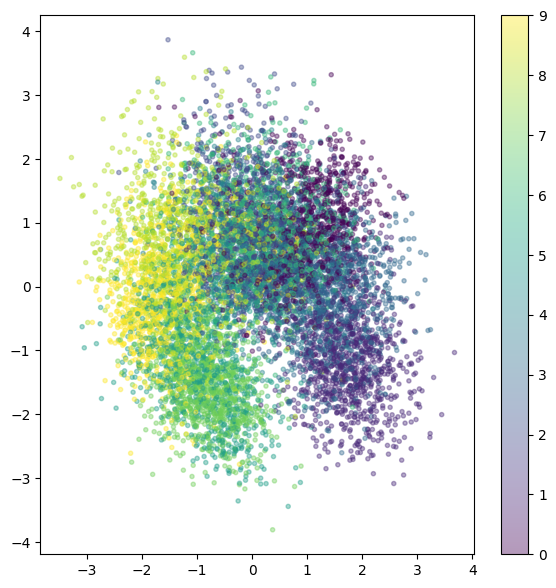

In [4]:
import numpy as np 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

def visualize_test_latent_space(net):
        ########################## TODO ##########################
        # visualizing test data using latent space features 

        # the shape should be : (num of test data, n_latent_features)
        test_data_latent_space = None 
        # the size should be : (num of test data)
        test_data_labels = None
        ######################## ( End ) #########################

    
        ########################## TODO ##########################
        # Apply PCA with 2 component on test_data_latent_space

        # the shape should be : (num of test data, 2)
        pca_test_data = None
        ######################## ( End ) #########################

        # scatter plot latent space
        plt.figure(figsize=(7, 7))
        plt.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c=test_labels,
                    alpha=.4, s=3**2, cmap='viridis')
        plt.colorbar()
        plt.show()

visualize_test_latent_space(net)

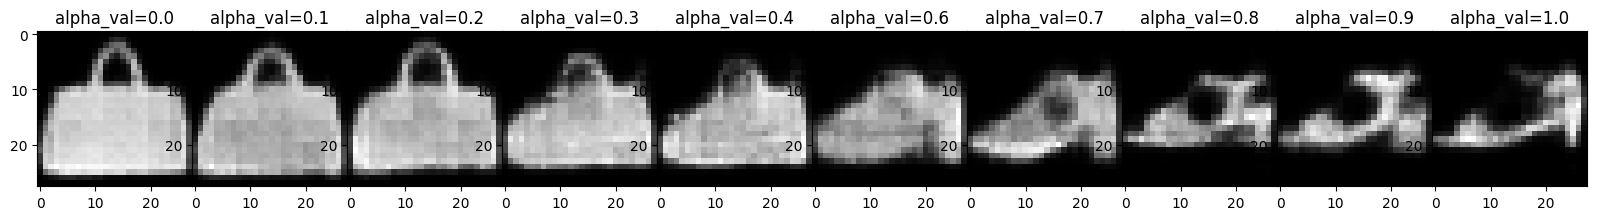

In [5]:
def interpolation_image(net, img1, img2, alpha):
    with torch.no_grad():
        ########################## TODO ##########################
        # z1 : latent vector of first image
        img1 = None  # send image to device and use unsqueeze(0)
        h = None
        z1, mu, logvar = None
        
        # z2: latent vector of second image
        img2 = None  # send image to device and use unsqueeze(0)
        h = None
        z2, mu, logvar = None
        ######################## ( End ) #########################
        
        # interpolation of the two latent vectors
        inter_latent = alpha* z1 + (1- alpha) * z2

        # reconstruct interpolated image
        inter_latent = net.fc4(inter_latent)
        d = net.decoder(inter_latent)
        inter_image = d.cpu()
        return inter_image
    

# interpolation alphas
alpha_range=np.linspace(0,1,10)

# select two random img from test_loader
num_test_data = len(net.test_loader.dataset)
img1 = net.test_loader.dataset[random.randint(0, num_test_data)][0]
img2 = net.test_loader.dataset[random.randint(0, num_test_data)][0]

# setup the plot
fig, axs = plt.subplots(1,10, figsize=(20, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for idx,a in enumerate(alpha_range):
    inter_image = interpolation_image(net, img1, img2, float(a))    
    image = inter_image.numpy()
    axs[idx].imshow(image[0,0,:,:], cmap='gray')
    axs[idx].set_title('alpha_val='+str(round(a,1)))
    
plt.show() 

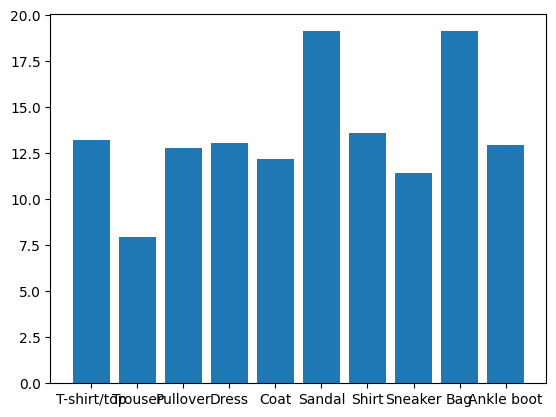

In [7]:
def plot_reconstruction_error(net):
    net.eval()
    total_reconstruction_error = dict.fromkeys(range(len(net.classes)), 0)
    ########################## TODO ##########################
    # calculate the mean squere error between test image and reconstructed one for all images in test data 
    # sum mse values of images in each class
    # total_reconstruction_error[class_n] = sum mse values of images in class_n
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(net.test_loader):
            pass
    ######################## ( End ) #########################

    plt.bar(net.classes, total_reconstruction_error.values())               
    
plot_reconstruction_error(net)